## Goal

Plot line graphs of the min and max temperatures for the years 2005 through 2014 highlighting the daily 2015 temperatures that exceeded those values.

## Dataset

The data comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily), which includes daily climate records from thousands of land surface stations across the globe. 

Here I use data from the Ann Arbor Michigan location.

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

In [18]:
#  I'll be using the folium package to render the data into a map in Jupyter.

import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('data/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
display(my_map)

### Step 1
Load the dataset and transform the data into Celsius (refer to documentation) then extract all of the rows which have minimum or maximum temperatures.

In [4]:
import pandas as pd
df = pd.read_csv('data/temperatures.csv')
df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [5]:
# In this code cell, transform the Data_Value column
df['Data_Value_Tenths'] = df['Data_Value'] / 10

## drop leap day
df['Date'] = pd.to_datetime(df['Date'])
df = df[~((df['Date'].dt.month == 2) & (df['Date'].dt.day == 29))]

df_max = df[df['Element'] == 'TMAX']
df_min = df[df['Element'] == 'TMIN']

print(df.shape, df_min.shape, df_max.shape)

(165002, 5) (81982, 5) (83020, 5)


### Step 2
In order to visualize the data we would plot the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But we also need to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

In [6]:
# create a DataFrame of maximum temperature by date
max_temp_date = df_max.groupby('Date')['Data_Value_Tenths'].max().reset_index()

# create a DataFrame of minimum temperatures by date
min_temp_date = df_min.groupby('Date')['Data_Value_Tenths'].min().reset_index()

print(max_temp_date.shape, min_temp_date.shape)

(4015, 2) (4015, 2)


### Step 3
Now that we have grouped the daily max and min temperatures for each day of the years 2005 through 2015, we can separate out the data for 2015.

In [7]:
import numpy as np

# calculate the minimum and maximum values for the day of the year for 2005 through 2014
max_temp_0514 = max_temp_date[max_temp_date['Date'].dt.year < 2015]
max_temp_0514 = max_temp_0514.groupby(max_temp_0514['Date'].dt.strftime('%m-%d')).agg({'Data_Value_Tenths': 'max'})
max_temp_0514.rename(columns={'Data_Value_Tenths': 'Max_Temp_0514'}, inplace=True)

min_temp_0514 = min_temp_date[min_temp_date['Date'].dt.year < 2015]
min_temp_0514 = min_temp_0514.groupby(min_temp_0514['Date'].dt.strftime('%m-%d')).agg({'Data_Value_Tenths': 'min'})
min_temp_0514.rename(columns={'Data_Value_Tenths': 'Min_Temp_0514'}, inplace=True)

# calculate the minimum and maximum values for the years 2015
max_temp_2015 = max_temp_date[max_temp_date['Date'].dt.year == 2015]
max_temp_2015 = max_temp_2015.groupby(max_temp_2015['Date'].dt.strftime('%m-%d')).agg({'Data_Value_Tenths': 'max'})
max_temp_2015.rename(columns={'Data_Value_Tenths': 'Max_Temp_2015'}, inplace=True)

min_temp_2015 = min_temp_date[min_temp_date['Date'].dt.year == 2015]
min_temp_2015 = min_temp_2015.groupby(min_temp_2015['Date'].dt.strftime('%m-%d')).agg({'Data_Value_Tenths': 'min'})
min_temp_2015.rename(columns={'Data_Value_Tenths': 'Min_Temp_2015'}, inplace=True)

## join df and find broken records
df_temp = pd.merge(max_temp_0514, min_temp_0514, on='Date').merge(max_temp_2015, on='Date').merge(min_temp_2015, on='Date')
df_temp['Broke_Record_Max'] = df_temp['Max_Temp_2015'] > df_temp['Max_Temp_0514']
df_temp['Broke_Record_Min'] = df_temp['Min_Temp_2015'] < df_temp['Min_Temp_0514']

print(max_temp_0514.shape, min_temp_0514.shape, max_temp_2015.shape, min_temp_2015.shape, df_temp.shape)

(365, 1) (365, 1) (365, 1) (365, 1) (365, 6)


### Step 4
Now it's time to plot!

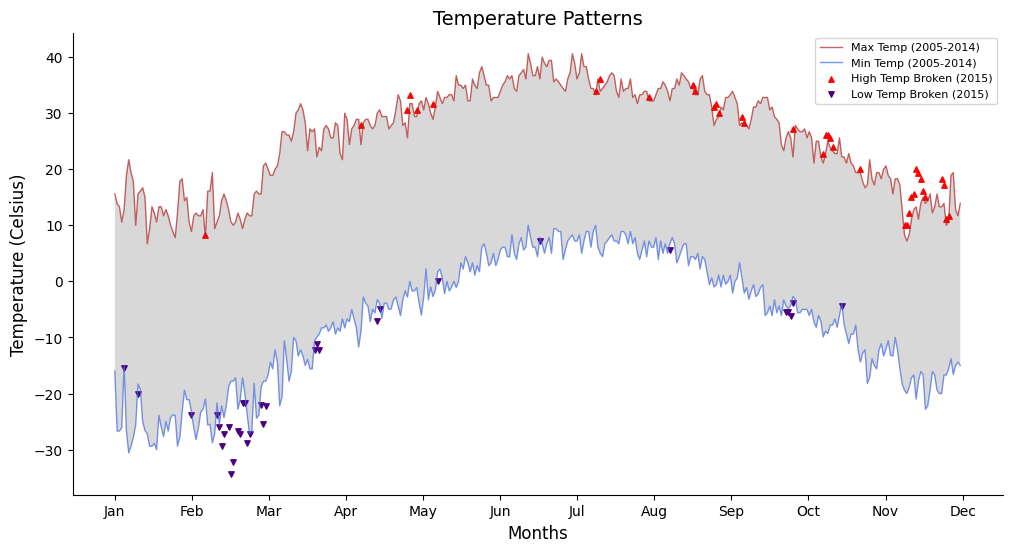

In [ ]:
import matplotlib.pyplot as plt
from calendar import month_abbr

# put your plotting code here!
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_temp['Max_Temp_0514'].values, label='Max Temp (2005-2014)', linewidth=1, alpha = 0.7, c='firebrick')
plt.plot(df_temp['Min_Temp_0514'].values, label='Min Temp (2005-2014)', linewidth=1, alpha = 0.7, c='royalblue')

plt.fill_between(range(df_temp.shape[0]), df_temp['Max_Temp_0514'], df_temp['Min_Temp_0514'], facecolor='gray', alpha=0.3)

plt.scatter(np.where(df_temp['Broke_Record_Max'] == True), 
            df_temp[df_temp['Broke_Record_Max'] == True]['Max_Temp_2015'].values,
            s=15, color='red', label='High Temp Broken (2015)', marker='^')
plt.scatter(np.where(df_temp['Broke_Record_Min'] == True), 
            df_temp[df_temp['Broke_Record_Min'] == True]['Min_Temp_2015'].values,
            s=15, color='indigo', label='Low Temp Broken (2015)', marker='v')

plt.legend(loc = 'upper right', fontsize=8)

plt.xticks(np.linspace(0, 365, num = 12), list(month_abbr)[1:], size=10)
plt.yticks(size=10)
plt.xlabel('Months', size = 12)
plt.ylabel('Temperature (Celsius)', size = 12)
plt.title('Temperature Patterns', size = 14)

ax.spines[['right', 'top']].set_visible(False)
# ax.spines[['bottom', 'left']].set_alpha(0.3)
# ax.tick_params(axis='x', color='gray')
# ax.tick_params(axis='y', color='gray')

# plt.savefig('temperature_plot.png')

plt.show()

### All in one 

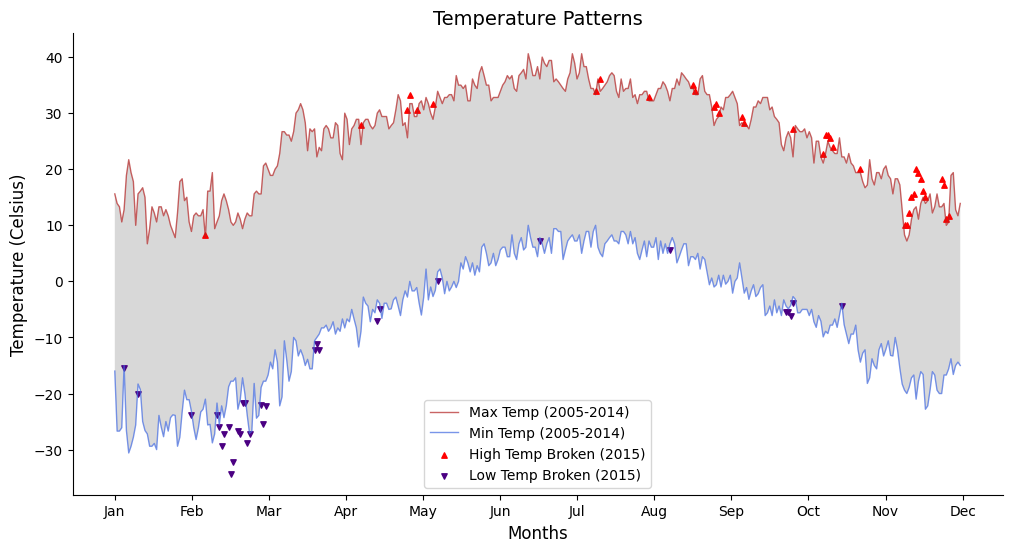

In [10]:
import pandas as pd
import numpy as np
from calendar import month_abbr

## load data
df = pd.read_csv('data/temperatures.csv')

## isolate year,month,day
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.strftime('%b') ## month short form
df['Day'] = df['Date'].dt.day

## sort month alphabethically
month_order = list(month_abbr)[1:]
df['Month'] = pd.Categorical(df['Month'], categories=month_order, ordered=True)

## drop leap day
df = df[~((df['Month'] == 'Feb') & (df['Day'] == 29))]

## transform temp
df['Data_Value'] = df['Data_Value'] / 10

## group temps
max_temp_0514 = df[(df['Element'] == 'TMAX') & (df['Year'] < 2015)].groupby(['Month','Day'], observed=True).agg({'Data_Value': 'max'})
min_temp_0514 = df[(df['Element'] == 'TMIN') & (df['Year'] < 2015)].groupby(['Month','Day'], observed=True).agg({'Data_Value': 'min'})
max_temp_2015 = df[(df['Element'] == 'TMAX') & (df['Year'] == 2015)].groupby(['Month','Day'], observed=True).agg({'Data_Value': 'max'})
min_temp_2015 = df[(df['Element'] == 'TMIN') & (df['Year'] == 2015)].groupby(['Month','Day'], observed=True).agg({'Data_Value': 'min'})

## rename
max_temp_0514.rename(columns={'Data_Value': 'Max_Temp_0514'}, inplace=True)
min_temp_0514.rename(columns={'Data_Value': 'Min_Temp_0514'}, inplace=True)
max_temp_2015.rename(columns={'Data_Value': 'Max_Temp_2015'}, inplace=True)
min_temp_2015.rename(columns={'Data_Value': 'Min_Temp_2015'}, inplace=True)

## join df and find broken records
df_temp = pd.merge(max_temp_0514, min_temp_0514, on=['Month', 'Day'])\
            .merge(max_temp_2015, on=['Month', 'Day'])\
            .merge(min_temp_2015, on=['Month', 'Day'])
df_temp['Broke_Record_Max'] = df_temp['Max_Temp_2015'] > df_temp['Max_Temp_0514']
df_temp['Broke_Record_Min'] = df_temp['Min_Temp_2015'] < df_temp['Min_Temp_0514']

## drop 29/30/31 in Feb because of merge
df_temp.dropna(inplace=True)

# plotting 
fig, ax = plt.subplots(figsize=(12, 6))

plt.plot(df_temp['Max_Temp_0514'].values, label='Max Temp (2005-2014)', linewidth=1, alpha = 0.7, c='firebrick')
plt.plot(df_temp['Min_Temp_0514'].values, label='Min Temp (2005-2014)', linewidth=1, alpha = 0.7, c='royalblue')

plt.fill_between(range(df_temp.shape[0]), df_temp['Max_Temp_0514'], df_temp['Min_Temp_0514'], facecolor='gray', alpha=0.3)

plt.scatter(np.where(df_temp['Broke_Record_Max'] == True), 
            df_temp[df_temp['Broke_Record_Max'] == True]['Max_Temp_2015'].values,
            s=15, color='red', label='High Temp Broken (2015)', marker='^')
plt.scatter(np.where(df_temp['Broke_Record_Min'] == True), 
            df_temp[df_temp['Broke_Record_Min'] == True]['Min_Temp_2015'].values,
            s=15, color='indigo', label='Low Temp Broken (2015)', marker='v')

plt.legend(loc = 'best', fontsize=10)

plt.xticks(np.linspace(0, 365, num = 12), list(month_abbr)[1:], size=10)
plt.yticks(size=10)
plt.xlabel('Months', size = 12)
plt.ylabel('Temperature (Celsius)', size = 12)
plt.title('Temperature Patterns', size = 14)

ax.spines[['right', 'top']].set_visible(False)
# ax.spines[['bottom', 'left']].set_alpha(0.3)
# ax.tick_params(axis='x', color='gray')
# ax.tick_params(axis='y', color='gray')

plt.show()
